# Installing the libraries and all the Imports

In [30]:
# --- Install the required library ---
!pip install compressai

# --- All necessary imports ---
import os
import io
import math
import time
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19

# --- CompressAI Imports ---
from compressai.layers import GDN, AttentionBlock, ResidualBlock
from compressai.entropy_models import EntropyBottleneck, GaussianConditional
from compressai.models.utils import conv, deconv



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameters and the device setup

In [31]:
# --- Setup GPU device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Dataset and Training Parameters ---
BATCH_SIZE = 8  # From your notes
PATCH_SIZE = 64 # Your 64x64 image size
TRAIN_PATH = "/content/drive/MyDrive/Collab_Data/subset_data"
TEST_PATH = "/content/drive/MyDrive/Collab_Data/test" # For final comparison

# --- Model Architecture Parameters (Chapter 3) ---
# N=256 for main convs, M=448 for bottleneck (from Figure 3.12)
NUM_FILTERS_N = 256
NUM_FILTERS_M = 448

# --- Optimizer Parameters (Section 3.1.2) ---
LEARNING_RATE = 1e-4  #
BETA_1 = 0.9          #
BETA_2 = 0.999        #

# --- Loss Function Parameters (Section 3.4.1) ---
# *** REMOVED LAMBDA_A_MSE and LAMBDA_B_VGG ***
# The AutomaticLossBalancer makes them redundant and causes explosions.

# --- Training Loop Parameters ---
NUM_EPOCHS = 200 # A good target
# (5000 images / 8 batch size) = 625 steps

SAVE_PATH = "/content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth"

Using device: cuda


# Data Loading & Augmentation


Loaded 5000 total training images.
Split into: 4000 training & 1000 validation images.
Loaded 19 test images.

Visualizing one augmented 64x64 batch:


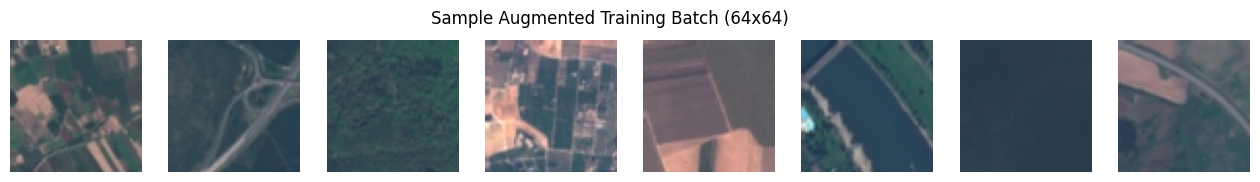

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split # Import random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Define Augmentations ---
train_transforms = transforms.Compose([
    transforms.RandomRotation([90, 90]),  # pi/2 rotation
    transforms.RandomAffine(degrees=0, shear=[-15, 15, -15, 15]),  # Shear mapping
    transforms.ToTensor(),  # Converts to [0, 1] float tensor
])

# For validation and testing, we just convert to tensor.
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# --- Custom Dataset for Flat Folder (Unchanged) ---
class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(root_dir)
            if os.path.isfile(os.path.join(root_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0

# --- Create Datasets and DataLoaders ---
try:
    # 1. Load the full training dataset
    full_train_dataset = FlatImageDataset(TRAIN_PATH, transform=train_transforms)

    # 2. Define split sizes (e.g., 80% train, 20% validation)
    VAL_SPLIT = 0.2
    val_size = int(len(full_train_dataset) * VAL_SPLIT)
    train_size = len(full_train_dataset) - val_size

    # 3. Create the splits
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # 4. Create the test dataset (with validation transforms)
    # We also apply the simpler transform to the val_dataset
    val_dataset.dataset.transform = val_test_transforms
    test_dataset = FlatImageDataset(TEST_PATH, transform=val_test_transforms)

    # 5. Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=2,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE, # Use the same batch size
        num_workers=2,
        shuffle=False, # No need to shuffle validation
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False,
        pin_memory=True,
    )

    print(f"Loaded {len(full_train_dataset)} total training images.")
    print(f"Split into: {len(train_dataset)} training & {len(val_dataset)} validation images.")
    print(f"Loaded {len(test_dataset)} test images.")

    # --- Visualize one batch to confirm ---
    print("\nVisualizing one augmented 64x64 batch:")
    img_batch, _ = next(iter(train_dataloader))
    fig, axes = plt.subplots(1, BATCH_SIZE, figsize=(16, 2))
    for i in range(BATCH_SIZE):
        img = img_batch[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle("Sample Augmented Training Batch (64x64)")
    plt.show()

except FileNotFoundError:
    print("---! ERROR !---")
    print(f"Could not find the dataset path: {TRAIN_PATH} or {TEST_PATH}")
    print("Please ensure your Google Drive is mounted and the paths in Cell 4 are correct.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check your data paths and file integrity.")

# Attention Module

In [33]:
# The paper's Attention Module (Figure 2.4 / 3.12) is a
# Squeeze-and-Excitation block.
# We can use the optimized, pre-built version from compressai.
CustomAttentionBlock = AttentionBlock
print("Using compressai.layers.AttentionBlock as the Attention Module.")

Using compressai.layers.AttentionBlock as the Attention Module.


# The VBR Autoencoder Model Core

In [34]:
class SatelliteVBR(nn.Module):
    """
    Full VBR Autoencoder model implementing all features from Chapter 3.
    This architecture is fully convolutional and will adapt to 64x64 inputs.
    g_a(64x64) -> y(4x4)
    h_a(y, 4x4) -> z(1x1)
    """
    def __init__(self, N=NUM_FILTERS_N, M=NUM_FILTERS_M):
        super().__init__()

        # --- Main Encoder (g_a) ---
        # 3x3 kernels, stride 2, 4 layers
        self.g_a = nn.Sequential(
            conv(3, N, kernel_size=3, stride=2),
            GDN(N), # Simplified GDN (Sec 3.2.2.3) [cite: 1175-1186]
            conv(N, N, kernel_size=3, stride=2),
            GDN(N),
            CustomAttentionBlock(N), # Attention Module (Sec 3.3.2) [cite: 1278-1286]
            conv(N, N, kernel_size=3, stride=2),
            GDN(N),
            conv(N, M, kernel_size=3, stride=2),
            CustomAttentionBlock(M), # Attention Module (Sec 3.3.2)
        )

        # --- Main Decoder (g_s) ---
        self.g_s = nn.Sequential(
            CustomAttentionBlock(M), # Attention Module
            deconv(M, N, kernel_size=3, stride=2),
            GDN(N, inverse=True),
            CustomAttentionBlock(N), # Attention Module
            deconv(N, N, kernel_size=3, stride=2),
            GDN(N, inverse=True),
            deconv(N, N, kernel_size=3, stride=2),
            GDN(N, inverse=True),
            deconv(N, 3, kernel_size=3, stride=2),
        )

        # --- Hyperprior (h_a and h_s) ---
        # *** FIX 1: Using LeakyReLU for better stability than ReLU ***
        self.h_a = nn.Sequential(
            conv(M, N, kernel_size=3, stride=1), # 3x3 kernel
            nn.LeakyReLU(inplace=True),
            conv(N, N, kernel_size=3, stride=2), # 3x3 kernel
            nn.LeakyReLU(inplace=True),
            conv(N, N, kernel_size=3, stride=2), # 3x3 kernel
        )

        self.h_s = nn.Sequential(
            deconv(N, N, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            deconv(N, N, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            deconv(N, M * 2, kernel_size=3, stride=1), # Output 2*M for mean and log_scale
        )

        # --- Entropy Models (from compressai) ---
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.gaussian_conditional = GaussianConditional(None) # None for variable scales

    def forward(self, x, gain):
        """
        Forward pass with Variable Bit Rate (VBR) Gain Unit. [cite: 1045-1050]
        'gain' is a [B, 1, 1, 1] tensor.
        """
        # --- VBR Gain Unit (Encoder) ---
        y = self.g_a(x)
        y_scaled = y * gain # This is the Gain Unit

        # --- Hyperprior Path ---
        z = self.h_a(y)
        z_hat, z_likelihoods = self.entropy_bottleneck(z)

        # Hyperprior decoder predicts mean and log_scale
        mean_scale = self.h_s(z_hat)
        mean, log_scale = mean_scale.chunk(2, 1) # Split M*2 into M (mean) and M (log_scale)

        # --- *** FIX 2: Exponentiate log_scale to get positive scale *** ---
        # This is the critical fix to prevent NaN.
        scale = torch.exp(log_scale)

        # --- Main Bottleneck Path ---
        y_hat_scaled, y_likelihoods = self.gaussian_conditional(y_scaled, scale, mean)

        # --- VBR Inverse Gain Unit (Decoder) ---
        y_hat = y_hat_scaled / gain

        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "likelihoods": {
                "y": y_likelihoods,
                "z": z_likelihoods,
            },
        }

# Perceptual Loss (VGG) Module

In [35]:
class VggPerceptualLoss(nn.Module):
    """
    Implements the perceptual loss (P)
    Uses early layers of VGG19.
    """
    def __init__(self):
        super(VggPerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features.to(device)
        vgg.eval()
        for param in vgg.parameters():
            param.requires_grad = False

        # Extract features from layers at "depths 2 and 4"
        # This corresponds to relu_2_2 (layer 9) and relu_4_2 (layer 27)
        self.features = nn.Sequential(
            *list(vgg.children())[:28]
        )
        self.feature_layers = [9, 27] # Indices for relu_2_2 and relu_4_2

        # VGG expects normalized input
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def forward(self, x_true, x_pred):
        x_true_norm = self.normalize(x_true)
        x_pred_norm = self.normalize(x_pred)

        loss = 0.0
        features_true = x_true_norm
        features_pred = x_pred_norm

        for i, layer in enumerate(self.features):
            features_true = layer(features_true)
            features_pred = layer(features_pred)

            if i in self.feature_layers:
                loss += F.mse_loss(features_true, features_pred)

        return loss

# Full Loss Function & Balancer

In [36]:
class AutomaticLossBalancer(nn.Module):
    """
    Implements the multi-loss balancing strategy from Sec 3.4.2, Eq 3.8
    This module is stateful.
    """
    def __init__(self, num_losses=2, T=2.0):
        super().__init__()
        self.num_losses = num_losses
        self.T = T
        # We register them as buffers so they are saved with the model state
        self.register_buffer("prev_losses", torch.ones(num_losses))
        self.register_buffer("prev_prev_losses", torch.ones(num_losses))

    def forward(self, current_losses_detached):
        # current_losses_detached is a *detached* tensor [L_mse, L_vgg]

        # wk = Lk(t-1) / Lk(t-2)
        w = self.prev_losses / (self.prev_prev_losses + 1e-6)

        # lambda_k = ...
        exp_w = torch.exp(w / self.T)
        sum_exp_w = torch.sum(exp_w)
        lambdas = (self.num_losses * exp_w) / sum_exp_w

        # Update history
        self.prev_prev_losses = self.prev_losses.clone()
        self.prev_losses = current_losses_detached.clone()

        return lambdas

class RateDistortionPerceptionLoss(nn.Module):
    """
    Full loss function L = (lambda_D * L_D + lambda_P * L_P) + alpha * R
    Based on Eq 3.7
    """
    def __init__(self):
        super().__init__()
        self.vgg_loss_fn = VggPerceptualLoss()

    def forward(self, x, out_net, lambda_mse, lambda_vgg, lambda_rate):
        x_hat = out_net["x_hat"]
        likelihoods = out_net["likelihoods"]
        num_pixels = x.size(0) * x.size(2) * x.size(3)

        # --- Rate Loss (R) ---
        rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
        rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
        rate_loss = rate_y + rate_z

        # --- Distortion Losses (D and P) ---
        # *** FIX: We use the RAW losses, not the scaled ones ***
        L_mse_raw = F.mse_loss(x, x_hat)
        L_vgg_raw = self.vgg_loss_fn(x, x_hat)

        # --- Total Loss (Eq 3.7) ---
        # The auto-balancer weights (lambda_mse, lambda_vgg) are now
        # applied to the raw losses.
        distortion_loss = (lambda_mse * L_mse_raw) + (lambda_vgg * L_vgg_raw)
        total_loss = distortion_loss + (lambda_rate * rate_loss)

        return {
            "loss": total_loss,
            "rate_bpp": rate_loss,
            "mse": L_mse_raw, # Return raw MSE
            "psnr": -10 * torch.log10(L_mse_raw),
            "vgg_loss": L_vgg_raw, # Return raw VGG
            "L_mse_weighted": L_mse_raw * lambda_mse, # For logging
            "L_vgg_weighted": L_vgg_raw * lambda_vgg  # For logging
        }

# Training Setup

In [37]:
# --- Instantiate Model and Helpers ---
model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)
criterion = RateDistortionPerceptionLoss().to(device)
balancer = AutomaticLossBalancer().to(device)

# --- Setup Optimizer ---
optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2) #
)

# --- Setup LR Scheduler (Sec 3.1.2) ---
# halved when the evaluation loss reaches a plateau of 10 epochs"
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5, # "halved"
    patience=10  # "plateau of 10 epochs"
)

print(f"Model, Loss, and Optimizer are ready for {PATCH_SIZE}x{PATCH_SIZE} images.")

Model, Loss, and Optimizer are ready for 64x64 images.


# Training Loop

In [38]:
from compressai.utils.eval_model.__main__ import psnr as compute_psnr
import time
import numpy as np

print("--- Starting Training (Fixed BPP Mode with Validation) ---")
best_loss = float('inf') # We now track the best *validation* loss

# --- SET YOUR FIXED TARGETS HERE ---
# To target ~2.0 bpp (based on the paper), let's use 0.5
TARGET_LAMBDA_RATE = 0.5

# Set a fixed gain. 1.0 is a neutral value.
TARGET_GAIN = 1.0
gain = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)
lambda_rate = TARGET_LAMBDA_RATE

print(f"Training with FIXED Lambda_Rate: {lambda_rate} and FIXED Gain: {TARGET_GAIN}")
# --- END OF NEW ---


for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train() # Set model to training mode
    epoch_loss = 0
    epoch_psnr = 0
    epoch_bpp = 0

    # We now iterate over the *entire* train_dataloader
    for i, (batch, _) in enumerate(train_dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()

        # --- Forward Pass ---
        # Use the fixed gain tensor (broadcasted to batch size)
        out_net = model(batch, gain.expand(batch.size(0), -1, -1, -1))

        # --- Loss Calculation ---
        with torch.no_grad(): # Balancer logic should not be part of graph
            L_mse_raw = F.mse_loss(batch, out_net["x_hat"])
            L_vgg_raw = criterion.vgg_loss_fn(batch, out_net["x_hat"])
            lambdas = balancer(torch.stack([L_mse_raw, L_vgg_raw]))
            lambda_mse, lambda_vgg = lambdas[0], lambdas[1]

        metrics = criterion(
            batch,
            out_net,
            lambda_mse=lambda_mse,
            lambda_vgg=lambda_vgg,
            lambda_rate=lambda_rate  # Use the fixed lambda_rate
        )

        # --- Backpropagation ---
        if torch.isnan(metrics["loss"]):
            print(f"Step {i}: Loss is NaN. Skipping step.")
            optimizer.zero_grad()
            continue

        metrics["loss"].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # --- Log Metrics ---
        epoch_loss += metrics["loss"].item()
        epoch_psnr += metrics["psnr"].item()
        epoch_bpp += metrics["rate_bpp"].item()

    # --- End of Training Phase ---
    avg_loss = epoch_loss / len(train_dataloader)
    avg_psnr = epoch_psnr / len(train_dataloader)
    avg_bpp = epoch_bpp / len(train_dataloader)


    # --- NEW: Validation Phase ---
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    epoch_val_psnr = 0
    epoch_val_bpp = 0

    with torch.no_grad():
        for batch, _ in val_dataloader:
            batch = batch.to(device)

            # Forward pass with fixed gain
            out_net = model(batch, gain.expand(batch.size(0), -1, -1, -1))

            # Loss calculation
            # We use the *same* balancer state, but don't update its history
            # (as it's only meant to track training loss trends)
            L_mse_raw = F.mse_loss(batch, out_net["x_hat"])
            L_vgg_raw = criterion.vgg_loss_fn(batch, out_net["x_hat"])
            lambdas = balancer(torch.stack([L_mse_raw, L_vgg_raw]))
            lambda_mse, lambda_vgg = lambdas[0], lambdas[1]

            metrics = criterion(
                batch,
                out_net,
                lambda_mse=lambda_mse,
                lambda_vgg=lambda_vgg,
                lambda_rate=lambda_rate
            )

            if not torch.isnan(metrics["loss"]):
                epoch_val_loss += metrics["loss"].item()
                epoch_val_psnr += metrics["psnr"].item()
                epoch_val_bpp += metrics["rate_bpp"].item()

    # --- End of Validation Phase ---
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    avg_val_psnr = epoch_val_psnr / len(val_dataloader)
    avg_val_bpp = epoch_val_bpp / len(val_dataloader)
    epoch_time = time.time() - epoch_start_time

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} ({epoch_time:.2f}s) - LR: {optimizer.param_groups[0]['lr']:.1e}")
    print(f"  TRAIN -> Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB, BPP: {avg_bpp:.3f}")
    print(f"  VALID -> Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.2f} dB, BPP: {avg_val_bpp:.3f}")

    # --- LR Scheduler & Checkpointing (NOW USES VALIDATION LOSS) ---
    scheduler.step(avg_val_loss) # Step based on validation loss

    if avg_val_loss < best_loss and not np.isnan(avg_val_loss):
        best_loss = avg_val_loss
        print(f"  -> New best VALIDATION loss: {best_loss:.4f}. Saving checkpoint to {SAVE_PATH}")
        torch.save(model.state_dict(), SAVE_PATH)

print("\n--- Training Complete ---")

--- Starting Training (Fixed BPP Mode with Validation) ---
Training with FIXED Lambda_Rate: 0.5 and FIXED Gain: 1.0

Epoch 1/200 (97.50s) - LR: 1.0e-04
  TRAIN -> Loss: 10.5153, PSNR: 11.74 dB, BPP: 0.925
  VALID -> Loss: 9.6675, PSNR: 12.89 dB, BPP: 0.555
  -> New best VALIDATION loss: 9.6675. Saving checkpoint to /content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth

Epoch 2/200 (53.62s) - LR: 1.0e-04
  TRAIN -> Loss: 8.4690, PSNR: 13.72 dB, BPP: 1.092
  VALID -> Loss: 8.8014, PSNR: 14.19 dB, BPP: 0.772
  -> New best VALIDATION loss: 8.8014. Saving checkpoint to /content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth

Epoch 3/200 (55.47s) - LR: 1.0e-04
  TRAIN -> Loss: 7.8164, PSNR: 14.57 dB, BPP: 1.185
  VALID -> Loss: 8.3619, PSNR: 14.82 dB, BPP: 0.893
  -> New best VALIDATION loss: 8.3619. Saving checkpoint to /content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth

Epoch 4/200 (54.88s) - LR: 1.0e-04
  TRAIN -> Loss: 7.2463, PSNR: 

Loading model from /content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth...
Successfully loaded best model weights.



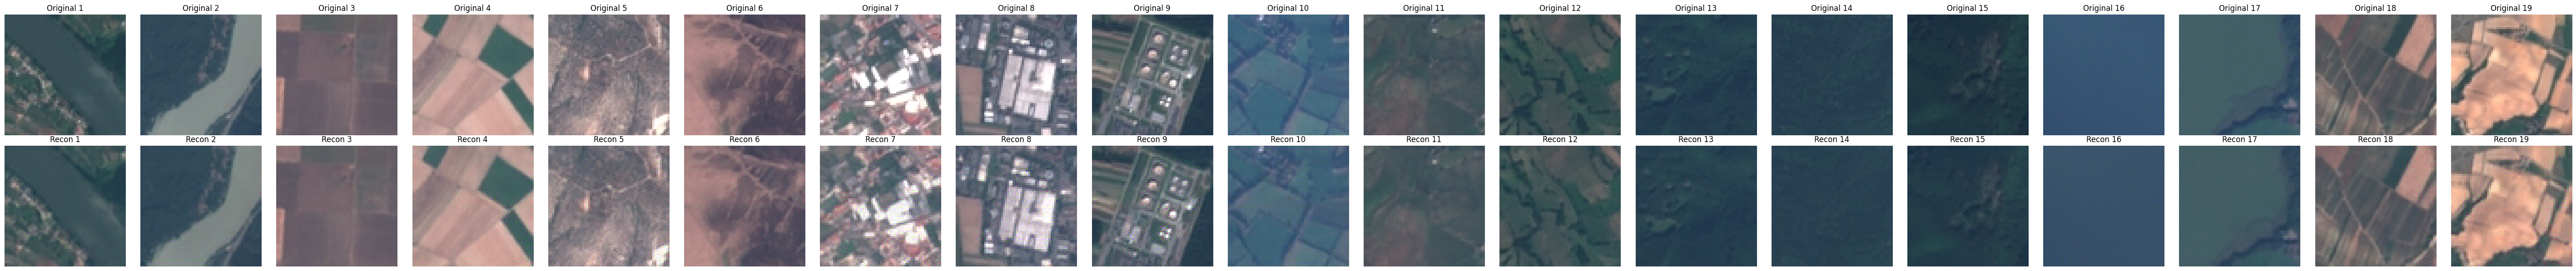


--- Display complete ---


In [39]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- 1. Load your trained model ---
print(f"Loading model from {SAVE_PATH}...")
inference_model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)

try:
    # Load weights
    state_dict = torch.load(SAVE_PATH, map_location=device)
    inference_model.load_state_dict(state_dict, strict=False)
    inference_model.eval()
    print("Successfully loaded best model weights.\n")

    # --- 2. Get all test images ---
    test_images = [f for f in os.listdir(TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not test_images:
        raise FileNotFoundError(f"No images found in {TEST_PATH}")

    # Limit display count if needed (to avoid overly long plots)
    MAX_SHOW = len(test_images)  # or set to 10, 20 etc.

    fig, axes = plt.subplots(2, MAX_SHOW, figsize=(3 * MAX_SHOW, 6))
    TARGET_GAIN = 1.0

    for idx, filename in enumerate(test_images[:MAX_SHOW]):
        test_image_path = os.path.join(TEST_PATH, filename)
        original_image_pil = Image.open(test_image_path).convert("RGB")
        original_image_tensor = test_transforms(original_image_pil).unsqueeze(0).to(device)

        # --- Model Inference ---
        gain_tensor = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)
        with torch.no_grad():
            output_dict = inference_model(original_image_tensor, gain_tensor)
            recon_image = output_dict["x_hat"].clamp_(0, 1)

        # Original
        axes[0, idx].imshow(original_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy())
        axes[0, idx].set_title(f"Original {idx+1}")
        axes[0, idx].axis("off")

        # Reconstructed
        axes[1, idx].imshow(recon_image.squeeze(0).cpu().permute(1, 2, 0).numpy())
        axes[1, idx].set_title(f"Recon {idx+1}")
        axes[1, idx].axis("off")

    plt.tight_layout()
    plt.show()

    print("\n--- Display complete ---")

except FileNotFoundError:
    print(f"\n---! ERROR !---")
    print(f"Could not find model at {SAVE_PATH} or images in {TEST_PATH}")
except Exception as e:
    print(f"\n---! ERROR During Evaluation !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


Loading model from /content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth...
Successfully loaded best model weights.

Found 19 test images. Running inference and metrics...
Processed River_15.jpg...
Processed River_26.jpg...
Processed AnnualCrop_1.jpg...
Processed AnnualCrop_3.jpg...
Processed HerbaceousVegetation_40.jpg...
Processed HerbaceousVegetation_1.jpg...
Processed Industrial_16.jpg...
Processed Industrial_26.jpg...
Processed Industrial_27.jpg...
Processed Pasture_1468.jpg...
Processed Pasture_1479.jpg...
Processed Pasture_1467.jpg...
Processed Forest_66.jpg...
Processed Forest_75.jpg...
Processed Forest_65.jpg...
Processed SeaLake_5.jpg...
Processed SeaLake_42.jpg...
Processed PermanentCrop_14.jpg...
Processed PermanentCrop_43.jpg...

Saved comparison plot to reconstruction_comparison_with_jpeg.png

--- Evaluation Complete ---
Your Model (Variable Rate, GAIN=1.0):
  Average PSNR: 32.8963 dB
  Average SSIM: 0.8871
  Average BPP:  1.3072 bpp

Standard JPEG (Targ

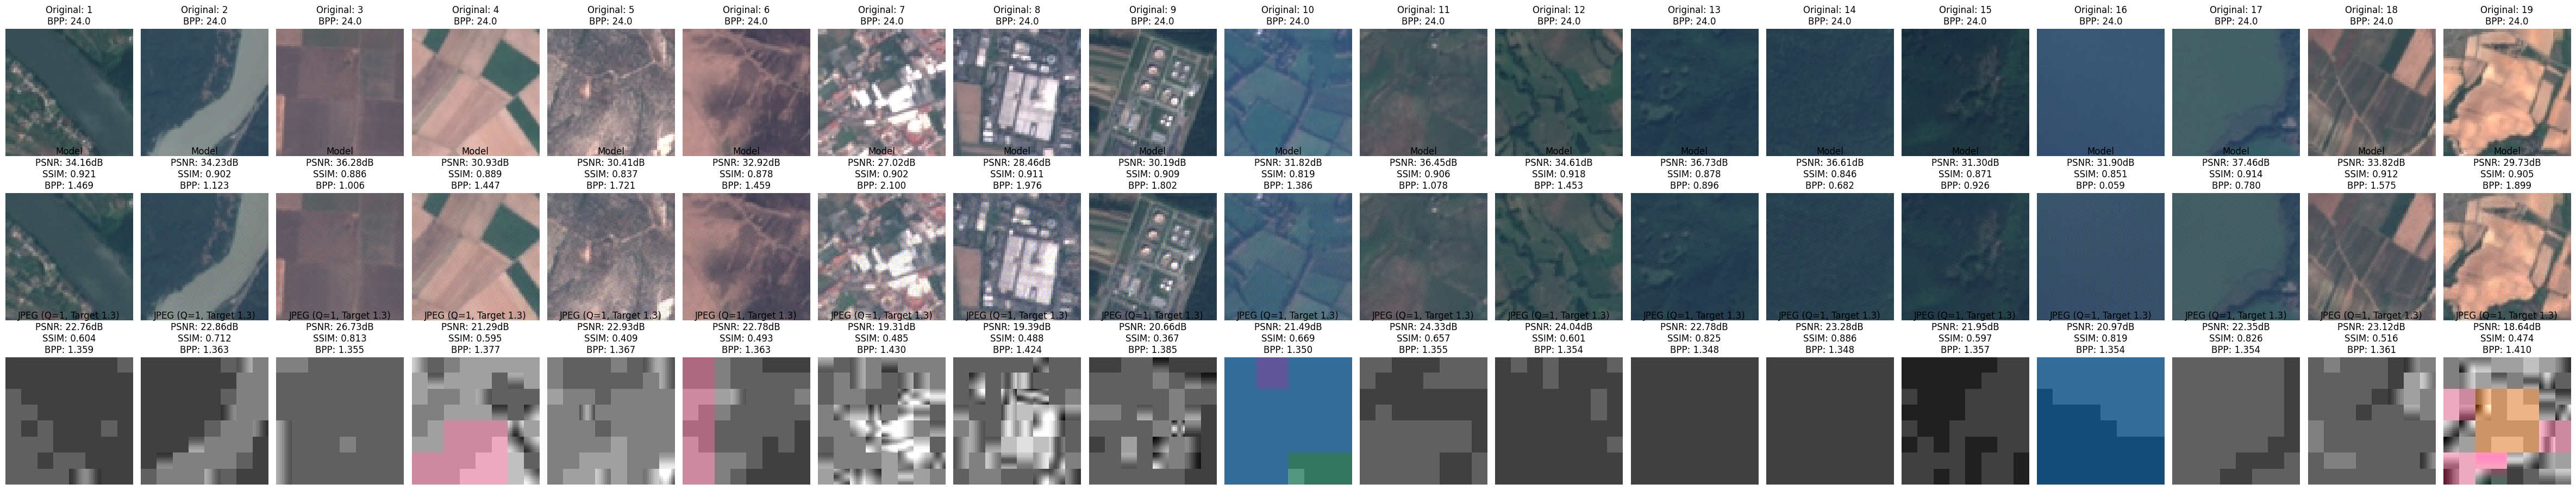

In [42]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import torch.nn.functional as F
import pytorch_msssim # We can use this since compressai installed it
import io # Required for in-memory JPEG compression

# --- Helper function for PSNR (for tensors in [0, 1] range) ---
def compute_psnr(a, b):
    mse = torch.mean((a - b) ** 2).item()
    if mse == 0:
        return float('inf')
    return -10 * math.log10(mse)

# --- NEW Helper function to get JPEG at a target BPP ---
def get_jpeg_at_bpp(image_pil, target_bpp, num_pixels):
    """
    Compresses a PIL image to JPEG, iteratively finding the highest
    quality (Q) that results in a BPP at or below the target_bpp.
    """
    target_bytes = (num_pixels * target_bpp) / 8.0

    # Search for the best quality setting (100 down to 1)
    for quality in range(100, 0, -1):
        buffer = io.BytesIO() # Create an in-memory buffer
        image_pil.save(buffer, format="JPEG", quality=quality)
        file_size = buffer.tell() # Get size in bytes

        if file_size <= target_bytes:
            # This is the highest quality at or below the target BPP
            actual_bpp = (file_size * 8) / num_pixels
            jpeg_image_pil = Image.open(buffer)
            return jpeg_image_pil, actual_bpp, quality

    # If target is too low (even quality=1 is too big)
    buffer = io.BytesIO()
    image_pil.save(buffer, format="JPEG", quality=1)
    file_size = buffer.tell()
    actual_bpp = (file_size * 8) / num_pixels
    jpeg_image_pil = Image.open(buffer)
    return jpeg_image_pil, actual_bpp, 1

# --- 1. Load your trained model ---
print(f"Loading model from {SAVE_PATH}...")
inference_model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)

try:
    state_dict = torch.load(SAVE_PATH, map_location=device)
    inference_model.load_state_dict(state_dict, strict=False)
    inference_model.eval()
    print("Successfully loaded best model weights.\n")

    # --- 2. Get all test images ---
    test_images = [f for f in os.listdir(TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not test_images:
        raise FileNotFoundError(f"No images found in {TEST_PATH}")

    num_images = len(test_images)
    print(f"Found {num_images} test images. Running inference and metrics...")

    # --- 3. Create the plot grid (MODIFIED FOR 3 ROWS) ---
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2.5, 9)) # 9 inches high for 3 rows

    # --- Targets ---
    TARGET_GAIN = 1.0 # For the model
    TARGET_BPP_JPEG = 1.3 # For JPEG <-- This line was changed

    gain_tensor = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)

    # Lists for model metrics
    model_psnr_scores = []
    model_ssim_scores = []
    model_bpp_scores = []

    # NEW lists for JPEG metrics
    jpeg_psnr_scores = []
    jpeg_ssim_scores = []
    jpeg_bpp_scores = []

    # --- 4. Loop, Infer, and Calculate Metrics ---
    for idx, filename in enumerate(test_images):
        test_image_path = os.path.join(TEST_PATH, filename)
        original_image_pil = Image.open(test_image_path).convert("RGB")
        original_image_tensor = test_transforms(original_image_pil).unsqueeze(0).to(device)

        num_pixels = original_image_tensor.size(2) * original_image_tensor.size(3)
        original_bpp = 24.0 # 8 bits * 3 channels

        # --- Plot Original Image (Row 1) ---
        axes[0, idx].imshow(original_image_pil)
        axes[0, idx].set_title(f"Original: {idx+1}\nBPP: {original_bpp:.1f}")
        axes[0, idx].axis("off")

        # --- Model Reconstruction (Row 2) ---
        with torch.no_grad():
            output_dict = inference_model(original_image_tensor, gain_tensor)
            recon_image_model = output_dict["x_hat"].clamp_(0, 1)

            # Calculate metrics for Model
            model_psnr_val = compute_psnr(recon_image_model, original_image_tensor)
            model_ssim_val = pytorch_msssim.ssim(recon_image_model, original_image_tensor, data_range=1.0).item()

            likelihoods = output_dict["likelihoods"]
            rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
            rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
            model_bpp_val = (rate_y + rate_z).item()

            model_psnr_scores.append(model_psnr_val)
            model_ssim_scores.append(model_ssim_val)
            model_bpp_scores.append(model_bpp_val)

        axes[1, idx].imshow(recon_image_model.squeeze(0).cpu().permute(1, 2, 0).numpy())
        axes[1, idx].set_title(f"Model\nPSNR: {model_psnr_val:.2f}dB\nSSIM: {model_ssim_val:.3f}\nBPP: {model_bpp_val:.3f}")
        axes[1, idx].axis("off")

        # --- NEW: JPEG Reconstruction (Row 3) ---
        # Find the best JPEG quality at or below the target BPP
        jpeg_pil, jpeg_bpp_val, jpeg_q = get_jpeg_at_bpp(original_image_pil, TARGET_BPP_JPEG, num_pixels)

        # Convert JPEG PIL image back to tensor for metrics
        recon_image_jpeg = test_transforms(jpeg_pil).unsqueeze(0).to(device)

        # Calculate metrics for JPEG
        jpeg_psnr_val = compute_psnr(recon_image_jpeg, original_image_tensor)
        jpeg_ssim_val = pytorch_msssim.ssim(recon_image_jpeg, original_image_tensor, data_range=1.0).item()

        jpeg_psnr_scores.append(jpeg_psnr_val)
        jpeg_ssim_scores.append(jpeg_ssim_val)
        jpeg_bpp_scores.append(jpeg_bpp_val)

        axes[2, idx].imshow(jpeg_pil)
        axes[2, idx].set_title(f"JPEG (Q={jpeg_q}, Target {TARGET_BPP_JPEG:.1f})\nPSNR: {jpeg_psnr_val:.2f}dB\nSSIM: {jpeg_ssim_val:.3f}\nBPP: {jpeg_bpp_val:.3f}")
        axes[2, idx].axis("off")

        print(f"Processed {filename}...")

    # --- 5. Save Plot ---
    plt.tight_layout()
    plt.savefig("reconstruction_comparison_with_jpeg.png") # Save the plot
    print(f"\nSaved comparison plot to reconstruction_comparison_with_jpeg.png")

    # --- 6. Print Average Scores ---
    avg_model_psnr = np.mean(model_psnr_scores)
    avg_model_ssim = np.mean(model_ssim_scores)
    avg_model_bpp = np.mean(model_bpp_scores)

    avg_jpeg_psnr = np.mean(jpeg_psnr_scores)
    avg_jpeg_ssim = np.mean(jpeg_ssim_scores)
    avg_jpeg_bpp = np.mean(jpeg_bpp_scores)

    print("\n--- Evaluation Complete ---")


    print("Your Model (Variable Rate, GAIN=1.0):")
    print(f"  Average PSNR: {avg_model_psnr:.4f} dB")
    print(f"  Average SSIM: {avg_model_ssim:.4f}")
    print(f"  Average BPP:  {avg_model_bpp:.4f} bpp")

    print(f"\nStandard JPEG (Targeting {TARGET_BPP_JPEG:.1f} BPP):")
    print(f"  Average PSNR: {avg_jpeg_psnr:.4f} dB")
    print(f"  Average SSIM: {avg_jpeg_ssim:.4f}")
    print(f"  Average BPP:  {avg_jpeg_bpp:.4f} bpp")


except FileNotFoundError:
    print(f"\n---! ERROR !---")
    print(f"Could not find model at {SAVE_PATH} or images in {TEST_PATH}")
except Exception as e:
    print(f"\n---! ERROR During Evaluation !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Loading model from /content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth...
Successfully loaded best model weights.

Loading and resizing test image: Industrial_56.jpg
Running model inference...
Running JPEG compression to match model BPP of 2.000...
Plotting comparison...
Saved plot to proof_of_concept_comparison.png


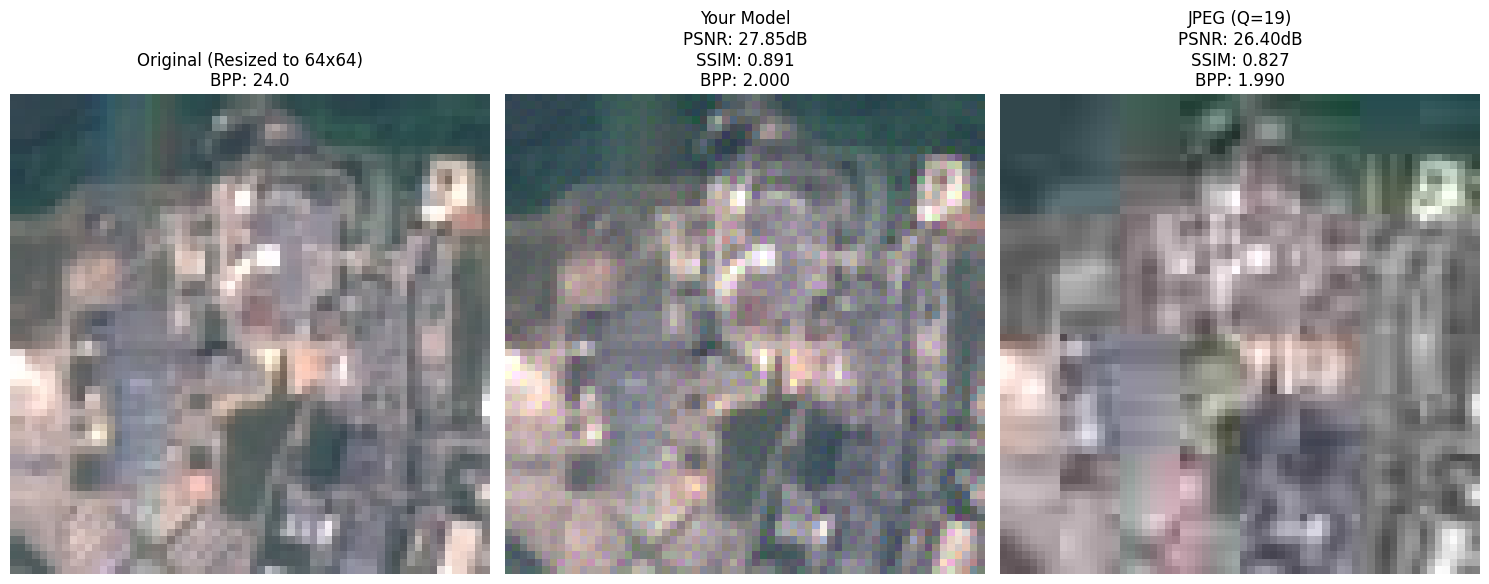

In [46]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import torch.nn.functional as F
import pytorch_msssim
import io

# --- Helper function for PSNR (for tensors in [0, 1] range) ---
def compute_psnr(a, b):
    mse = torch.mean((a - b) ** 2).item()
    if mse == 0:
        return float('inf')
    return -10 * math.log10(mse)

# --- Helper function to get JPEG at a target BPP ---
def get_jpeg_at_bpp(image_pil, target_bpp, num_pixels):
    """
    Compresses a PIL image to JPEG, iteratively finding the highest
    quality (Q) that results in a BPP at or below the target_bpp.
    """
    target_bytes = (num_pixels * target_bpp) / 8.0

    for quality in range(100, 0, -1):
        buffer = io.BytesIO()
        image_pil.save(buffer, format="JPEG", quality=quality)
        file_size = buffer.tell()

        if file_size <= target_bytes:
            actual_bpp = (file_size * 8) / num_pixels
            jpeg_image_pil = Image.open(buffer)
            return jpeg_image_pil, actual_bpp, quality

    # Fallback for very low BPP targets
    buffer = io.BytesIO()
    image_pil.save(buffer, format="JPEG", quality=1)
    file_size = buffer.tell()
    actual_bpp = (file_size * 8) / num_pixels
    jpeg_image_pil = Image.open(buffer)
    return jpeg_image_pil, actual_bpp, 1

# --- 1. Define Parameters ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# !! IMPORTANT: Set this to your folder with high-res images !!
HIGH_RES_TEST_PATH = "/content/drive/MyDrive/Collab_Data/high_quality_images" # <-- CHANGE THIS
SAVE_PATH = "/content/drive/MyDrive/AI_Models/Images_project/Improvement_2/model.pth"

# Model parameters from your notebook
NUM_FILTERS_N = 256
NUM_FILTERS_M = 448
TARGET_GAIN = 1.0 # Use 1.0 for a neutral comparison

# --- 2. Define Image Transforms (Using your definitions) ---
# For resizing the new PIL image
pil_resizer = transforms.Resize((64, 64))
# From your Cell 5, for converting PIL to Tensor
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# --- 3. Load Model ---
# This assumes the SatelliteVBR class is defined above in your notebook
print(f"Loading model from {SAVE_PATH}...")
inference_model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)

try:
    state_dict = torch.load(SAVE_PATH, map_location=device)
    inference_model.load_state_dict(state_dict, strict=False)
    inference_model.eval()
    print("Successfully loaded best model weights.\n")

    # --- 4. Load ONE High-Res Image ---
    all_files = [f for f in os.listdir(HIGH_RES_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_files:
        raise FileNotFoundError(f"No images found in {HIGH_RES_TEST_PATH}. Please upload an image.")

    test_image_filename = all_files[0] # Get the first image
    test_image_path = os.path.join(HIGH_RES_TEST_PATH, test_image_filename)
    print(f"Loading and resizing test image: {test_image_filename}")

    high_res_pil = Image.open(test_image_path).convert("RGB")

    # --- 5. Prepare Images ---
    # 1. Create the 64x64 PIL version (for JPEG and display)
    resized_pil = pil_resizer(high_res_pil)

    # 2. Create the 64x64 Tensor version (for model and metrics)
    original_tensor = test_transforms(resized_pil).unsqueeze(0).to(device)

    num_pixels = original_tensor.size(2) * original_tensor.size(3)
    gain_tensor = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)

    # --- 6. Run Model Inference ---
    print("Running model inference...")
    with torch.no_grad():
        output_dict = inference_model(original_tensor, gain_tensor)
        recon_image_model = output_dict["x_hat"].clamp_(0, 1)

        # Calculate metrics for Model
        model_psnr = compute_psnr(recon_image_model, original_tensor)
        model_ssim = pytorch_msssim.ssim(recon_image_model, original_tensor, data_range=1.0).item()

        likelihoods = output_dict["likelihoods"]
        rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
        rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
        model_bpp = (rate_y + rate_z).item()

    # --- 7. Run JPEG Comparison ---
    print(f"Running JPEG compression to match model BPP of {model_bpp:.3f}...")
    # Target the same BPP as the model
    jpeg_pil, jpeg_bpp, jpeg_q = get_jpeg_at_bpp(resized_pil, model_bpp, num_pixels)

    # Convert JPEG PIL image back to tensor for metrics
    recon_image_jpeg = test_transforms(jpeg_pil).unsqueeze(0).to(device)

    # Calculate metrics for JPEG
    jpeg_psnr = compute_psnr(recon_image_jpeg, original_tensor)
    jpeg_ssim = pytorch_msssim.ssim(recon_image_jpeg, original_tensor, data_range=1.0).item()

    # --- 8. Plot Results ---
    print("Plotting comparison...")
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # Original (64x64)
    axes[0].imshow(resized_pil)
    axes[0].set_title(f"Original (Resized to 64x64)\nBPP: 24.0")
    axes[0].axis("off")

    # Model Reconstruction
    axes[1].imshow(recon_image_model.squeeze(0).cpu().permute(1, 2, 0).numpy())
    axes[1].set_title(f"Your Model\nPSNR: {model_psnr:.2f}dB\nSSIM: {model_ssim:.3f}\nBPP: {model_bpp:.3f}")
    axes[1].axis("off")

    # JPEG Reconstruction
    axes[2].imshow(jpeg_pil)
    axes[2].set_title(f"JPEG (Q={jpeg_q})\nPSNR: {jpeg_psnr:.2f}dB\nSSIM: {jpeg_ssim:.3f}\nBPP: {jpeg_bpp:.3f}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig("proof_of_concept_comparison.png")
    print("Saved plot to proof_of_concept_comparison.png")

except FileNotFoundError:
    print(f"\n---! ERROR !---")
    print(f"Could not find model at {SAVE_PATH} or image at {HIGH_RES_TEST_PATH}")
    print("Please make sure you have created the folder, uploaded an image, and updated the HIGH_RES_TEST_PATH variable.")
except Exception as e:
    print(f"\n---! ERROR During Evaluation !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()